<a href="https://colab.research.google.com/github/rendrasatriar/Density-SILO/blob/Bintangor/Bintangor_BRK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
!pip install --quiet google-cloud-bigquery pandas pyarrow

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "study-density-silo"
DATASET_ID = "study_density"
TABLE_ID = "raw_data_bintangor"

client = bigquery.Client(project=PROJECT_ID)

def fetch_single_block(project: str, dataset: str, table_id: str, max_rows: int = None) -> pd.DataFrame:
    table_full = f"{project}.{dataset}.{table_id}"
    query = f"SELECT * FROM `{table_full}`"
    job = client.query(query)
    if max_rows:
        return job.result(max_results=max_rows).to_dataframe()
    return job.to_dataframe()

In [5]:
# --- Ambil data satu blok ---
df_block = fetch_single_block(PROJECT_ID, DATASET_ID, TABLE_ID)
print(f"Loaded table: {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}")
print("Rows:", len(df_block))
print("Columns:", len(df_block.columns))
print("Shape:", df_block.shape)
print("-" * 60)

# --- Informasi kolom dan tipe data ---
print("\nColumn info:")
print(df_block.dtypes)
print("\nMemory usage (MB):")
print(df_block.memory_usage(deep=True).sum() / 1024**2)

# --- Statistik numerik singkat ---
print("\nDescriptive statistics (numeric columns):")
display(df_block.describe().transpose())

# --- Distribusi kategori penting ---
if 'GEN_LYR' in df_block.columns:
    print("\nUnique GEN_LYR count:", df_block['GEN_LYR'].nunique())
    print("Top GEN_LYR value counts:")
    display(df_block['GEN_LYR'].value_counts().head(20))

if 'Material' in df_block.columns:
    print("\nUnique Material count:", df_block['Material'].nunique())
    print("Top Material value counts:")
    display(df_block['Material'].value_counts().head(20))

# --- Quick QAQC checks ---
print("\nQAQC checks:")
if {'Interval','From','To'}.issubset(df_block.columns):
    n_bad_interval = len(df_block[(df_block['Interval'] <= 0) | (df_block['To'] <= df_block['From'])])
    print("Rows with Interval <= 0 or To <= From:", n_bad_interval)
else:
    print("Columns Interval/From/To not all present for QAQC checks.")

Loaded table: study-density-silo.study_density.raw_data_bintangor
Rows: 11548
Columns: 16
Shape: (11548, 16)
------------------------------------------------------------

Column info:
HoleId         object
Hill           object
Hill_Group     object
From          float64
To            float64
Interval      float64
CoreRec       float64
WetW          float64
H2O           float64
DryW          float64
Material       object
Layer          object
NEW_LYR        object
GEN_LYR        object
WTF           float64
DTF           float64
dtype: object

Memory usage (MB):
4.864101409912109

Descriptive statistics (numeric columns):


,count,mean,std,min,25%,50%,75%,max
From,11548.0,5.680615,3.949815,0.000000,2.600000,5.075000,8.000000,23.000000
To,11548.0,6.448785,3.934414,0.200000,3.000000,6.000000,9.000000,23.900000
Interval,11548.0,0.768170,0.290259,0.050000,0.500000,1.000000,1.000000,3.000000
CoreRec,11548.0,1.081167,0.188022,0.200000,1.000000,1.000000,1.090000,3.500000
WetW,11548.0,4.179988,1.862441,0.400000,2.640000,4.259500,5.515000,13.340000
H2O,11548.0,25.032835,14.841084,0.079000,12.402250,25.364500,36.083250,90.147000
DryW,11548.0,3.181767,1.628951,0.156000,1.835000,3.057500,4.336000,11.840000
WTF,11548.0,1.756388,0.571895,0.195304,1.489770,1.723069,1.953043,23.925631
DTF,11548.0,1.335409,0.587918,0.123134,0.992927,1.266640,1.612504,22.471965



Unique GEN_LYR count: 5
Top GEN_LYR value counts:


,count
GEN_LYR,
LIM,5803
BRK,2925
SAP,2291
SAPX,312
LIMX,217



Unique Material count: 50
Top Material value counts:


,count
Material,
YLIM,2423
Rlim,1583
ESAP,1572
HGT,933
HSAP,882
RSAP,831
Sap,700
RLIM,380
DNT,365



QAQC checks:
Rows with Interval <= 0 or To <= From: 0


# Filter By GEN_LYR

In [7]:
gen_lyr_input = input("Masukkan GEN_LYR yang ingin difilter: ").strip()

# Input beberapa material, pisahkan dengan koma
materials_input = input("Masukkan Material yang ingin difilter (pisahkan dengan koma): ").strip()
materials_list = [m.strip().upper() for m in materials_input.split(",")]

df_filtered = df_block.copy()

# Filter GEN_LYR
if 'GEN_LYR' in df_filtered.columns:
    df_filtered = df_filtered[df_filtered['GEN_LYR'].str.upper() == gen_lyr_input.upper()]

# Filter Material (lebih dari satu)
if 'Material' in df_filtered.columns and len(materials_list) > 0:
    df_filtered = df_filtered[df_filtered['Material'].str.upper().isin(materials_list)]

print(f"\nFiltered rows: {len(df_filtered)}")
display(df_filtered.head(133))

Masukkan GEN_LYR yang ingin difilter: BRK
Masukkan Material yang ingin difilter (pisahkan dengan koma): BR_1,BR_2,BR_3,BR_4,BR_5,RSAP,DNT,HSAP,HGT,SPT,SPT/HGT,BR,HGT/BR,Hsapx,LST,LZT,GBR

Filtered rows: 2792


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
1821,CS7210355,Bintangor Blok 1 Spasi 50,BINTANGOR,1.50,2.0,0.50,1.00,2.330,10.300,2.090,HSAP,None,BRK,BRK,1.593902,1.429723
1853,CS7210128,Bintangor Blok 2 Spasi 50,BINTANGOR,1.55,2.6,1.05,1.00,6.360,5.818,5.990,SPT,None,BRK,BRK,2.071779,1.951251
1895,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.65,2.0,0.35,1.00,2.374,5.223,2.250,SPT,None,BRK,BRK,2.320002,2.198822
1924,CS7210126,Bintangor Blok 2 Spasi 50,BINTANGOR,1.75,2.8,1.05,1.00,6.434,6.839,5.994,SPT,None,BRK,BRK,2.095885,1.952554
1925,CS7210354,Bintangor Blok 1 Spasi 50,BINTANGOR,1.75,3.0,1.25,1.00,7.250,1.103,7.170,HGT,None,BRK,BRK,1.983826,1.961936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5107,CD02436,BINTANGOR BARAT UTARA,BINTANGOR,5.00,6.0,1.00,1.00,1.971,2.202,1.928,BR_2,None,BRK,BRK,0.674159,0.659315
5108,CS7210358,Bintangor Blok 1 Spasi 50,BINTANGOR,5.00,6.0,1.00,0.95,5.920,3.547,5.710,HGT,None,BRK,BRK,2.131443,2.055835
5109,CS7210153,Bintangor Blok 1 Spasi 50,BINTANGOR,5.00,6.0,1.00,1.00,5.420,8.303,4.970,HSAP,None,BRK,BRK,1.853852,1.699934
5111,CD500080,BINTANGOR BARAT UTARA,BINTANGOR,5.00,6.0,1.00,1.00,6.472,1.653,6.365,HSAP,None,BRK,BRK,2.213677,2.177078


# Filter By Interval

Descriptive statistics for Interval:
Count: 2792
Mean: 0.838188
Standard Error: 0.005329
Median: 1.0
Mode: 1.0
Standard Deviation: 0.281563
Sample Variance: 0.079277
Kurtosis: 1.189121
Skewness: -0.393002
Range: 2.9
Minimum: 0.1
Maximum: 3.0
Sum: 2340.22
Confidence Level (95%): ±0.010448

Bin calculation:
Freedman–Diaconis -> bins: 52, bin width: 0.056813
Sturges -> bins: 13, bin width: 0.223077


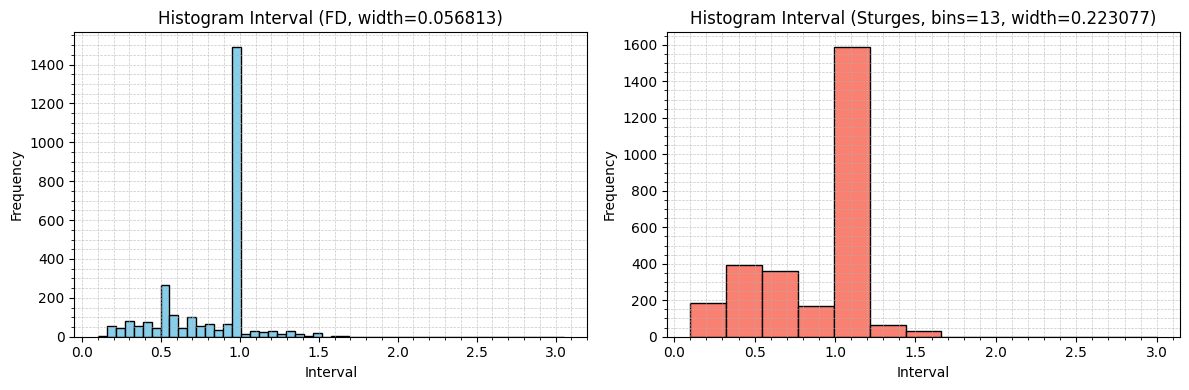


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.100000,0.156813,5
1,0.156813,0.213627,56
2,0.213627,0.270440,43
3,0.270440,0.327254,81
4,0.327254,0.384067,56
5,0.384067,0.440881,78
6,0.440881,0.497694,43
7,0.497694,0.554508,264
8,0.554508,0.611321,110
9,0.611321,0.668135,47



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.100000,0.323077,185
1,0.323077,0.546154,393
2,0.546154,0.769231,361
3,0.769231,0.992308,170
4,0.992308,1.215385,1589
5,1.215385,1.438462,62
6,1.438462,1.661538,29
7,1.661538,1.884615,1
8,1.884615,2.107692,0
9,2.107692,2.330769,0


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return int(np.sqrt(n)), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series):
    data = series.dropna().values
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    se = stats.sem(data)
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0] if n > 0 else None
    var = np.var(data, ddof=1)
    kurt = stats.kurtosis(data)
    skew = stats.skew(data)
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else None

    print("Descriptive statistics for Interval:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}")
    print(f"Sample Variance: {var:.6f}")
    print(f"Kurtosis: {kurt:.6f}")
    print(f"Skewness: {skew:.6f}")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): \u00b1{conf95:.6f}")

def plot_interval_histograms(df_filtered):
    if 'Interval' not in df_filtered.columns:
        print("Kolom 'Interval' tidak ada di dataframe.")
        return

    data = df_filtered['Interval'].dropna()

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data)

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins: {bins_fd}, bin width: {width_fd_str}")
    print(f"Sturges -> bins: {bins_st}, bin width: {width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram Interval (FD, width={width_fd_str})")
    axes[0].set_xlabel("Interval")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram Interval (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("Interval")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
interval_data = plot_interval_histograms(df_filtered) # Corrected function call

In [9]:
# Pastikan df_filtered sudah ada
# Contoh: df_filtered = filter_data(df_block, "LIM", "RLIM")

# Minta input dari user
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))

# Filter data sesuai input
df_interval = df_filtered[(df_filtered['Interval'] >= lower_bound) &
                       (df_filtered['Interval'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_interval)}")
display(df_interval.head(50))

Masukkan batas bawah (is greater than or equal to): 0.952202
Masukkan batas atas (is less than or equal to): 1.009016

Filtered rows: 1491


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
1957,CS7210355,Bintangor Blok 1 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.00,5.090,7.662,4.700,HGT,None,BRK,BRK,1.740979,1.607583
1958,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,2.0,3.0,1.0,0.95,5.285,6.509,4.941,BR_1,None,BRK,BRK,1.902912,1.779054
1959,CD00096,MANGGURUH UTARA,BINTANGOR,2.0,3.0,1.0,1.00,5.950,3.133,5.764,BR_2,None,BRK,BRK,2.035132,1.971368
1960,CD500074,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.00,6.208,4.317,5.940,SPT,None,BRK,BRK,2.123378,2.031712
1961,CD500081,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.00,5.160,0.717,5.123,HSAP,None,BRK,BRK,1.764921,1.752266
1962,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.00,5.625,4.782,5.356,SPT,None,BRK,BRK,1.923970,1.831961
2973,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.00,5.757,5.556,5.437,BR_2,None,BRK,BRK,1.969119,1.859723
2974,CD500090,BINTANGOR BARAT UTARA,BINTANGOR,3.0,4.0,1.0,1.00,6.834,1.463,6.734,HGT,None,BRK,BRK,2.337632,2.303428
2975,CD500160,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.00,4.030,9.578,3.644,HSAP,None,BRK,BRK,1.378417,1.246390
2976,CS7210119,Bintangor Blok 2 Spasi 50,BINTANGOR,3.0,4.0,1.0,1.00,3.590,8.691,3.278,HSAP,None,BRK,BRK,1.227920,1.121204


# Filter By Recovery


Descriptive statistics for CoreRec:
Count: 1491
Mean: 0.985748
Standard Error: 0.001217
Median: 1.0
Mode: 1.0
Standard Deviation: 0.046986
Sample Variance: 0.002208
Kurtosis: 20.224028
Skewness: -2.994450
Range: 0.75
Minimum: 0.5
Maximum: 1.25
Sum: 1469.75
Confidence Level (95%): ±0.002387

Bin calculation:
Freedman–Diaconis -> bins=38, width=N/A
Sturges -> bins=12, width=0.062500


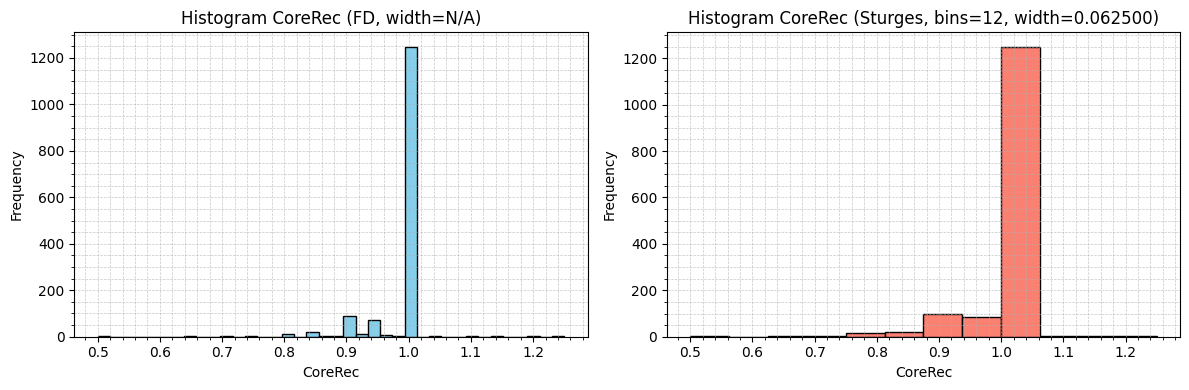


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.500000,0.519737,1
1,0.519737,0.539474,0
2,0.539474,0.559211,0
3,0.559211,0.578947,0
4,0.578947,0.598684,0
5,0.598684,0.618421,0
6,0.618421,0.638158,0
7,0.638158,0.657895,2
8,0.657895,0.677632,0
9,0.677632,0.697368,0



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.5000,0.5625,1
1,0.5625,0.6250,0
2,0.6250,0.6875,2
3,0.6875,0.7500,5
4,0.7500,0.8125,16
5,0.8125,0.8750,21
6,0.8750,0.9375,100
7,0.9375,1.0000,87
8,1.0000,1.0625,1249
9,1.0625,1.1250,2


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="CoreRec"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_coreRec(df_interval):
    if 'CoreRec' not in df_interval.columns:
        print("Kolom 'CoreRec' tidak ada di dataframe.")
        return

    data = df_interval['CoreRec'].dropna()
    if data.empty:
        print("Tidak ada data 'CoreRec' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="CoreRec")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram CoreRec (FD, width={width_fd_str})")
    axes[0].set_xlabel("CoreRec")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram CoreRec (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("CoreRec")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
coreRec_data = analyze_coreRec(df_interval)

In [11]:
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))


df_recovery = df_interval[(df_interval['CoreRec'] >= lower_bound) &
                       (df_interval['CoreRec'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_recovery)}")
display(df_recovery.head(47))

Masukkan batas bawah (is greater than or equal to): 0.993421
Masukkan batas atas (is less than or equal to): 1.013158

Filtered rows: 1248


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
1957,CS7210355,Bintangor Blok 1 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.0,5.090,7.662,4.700,HGT,None,BRK,BRK,1.740979,1.607583
1959,CD00096,MANGGURUH UTARA,BINTANGOR,2.0,3.0,1.0,1.0,5.950,3.133,5.764,BR_2,None,BRK,BRK,2.035132,1.971368
1960,CD500074,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.0,6.208,4.317,5.940,SPT,None,BRK,BRK,2.123378,2.031712
1961,CD500081,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.0,5.160,0.717,5.123,HSAP,None,BRK,BRK,1.764921,1.752266
1962,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.0,5.625,4.782,5.356,SPT,None,BRK,BRK,1.923970,1.831961
2973,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.0,5.757,5.556,5.437,BR_2,None,BRK,BRK,1.969119,1.859723
2974,CD500090,BINTANGOR BARAT UTARA,BINTANGOR,3.0,4.0,1.0,1.0,6.834,1.463,6.734,HGT,None,BRK,BRK,2.337632,2.303428
2975,CD500160,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.0,4.030,9.578,3.644,HSAP,None,BRK,BRK,1.378417,1.246390
2976,CS7210119,Bintangor Blok 2 Spasi 50,BINTANGOR,3.0,4.0,1.0,1.0,3.590,8.691,3.278,HSAP,None,BRK,BRK,1.227920,1.121204
2979,CD500213,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.0,4.108,20.594,3.262,RSAP,None,BRK,BRK,1.405096,1.115731


# Filter By Wet Weight


Residual IQR acuan:
Q1: -0.525, Q3: 0.607, IQR: 1.132
Lower margin: -2.223, Upper margin: 2.304


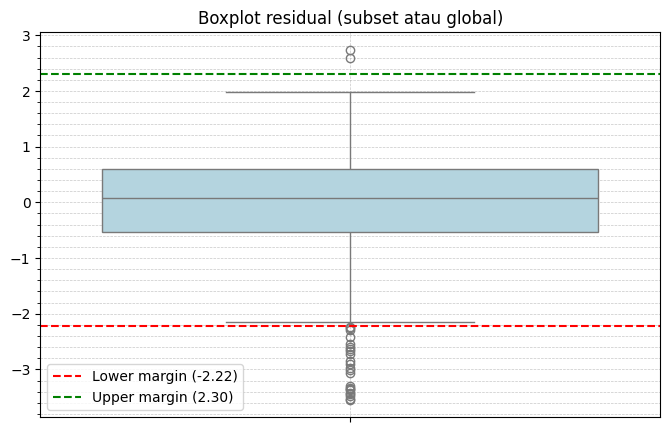

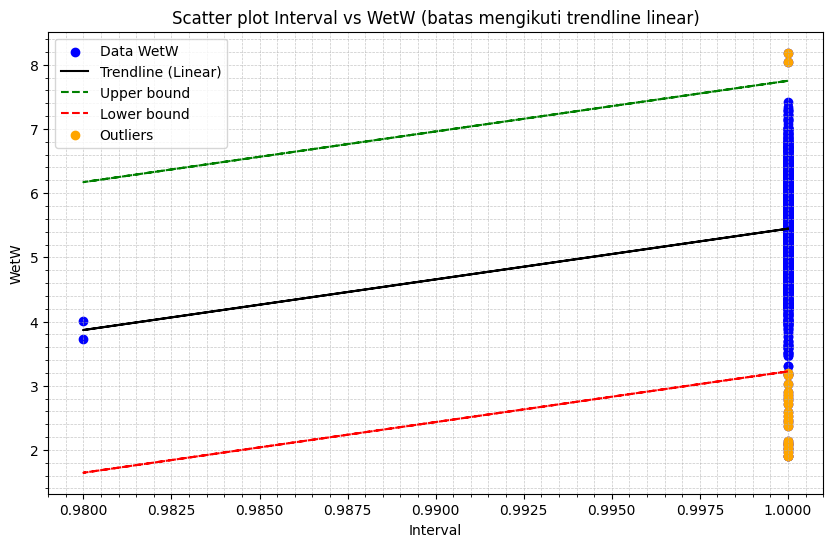


Outlier WetW berdasarkan trendline linear + IQR residual acuan:
         HoleId                       Hill Hill_Group  From   To  Interval  \
4033  CS6210159  Bintangor Blok 2 Spasi 25  BINTANGOR   4.0  5.0       1.0   
4041   CD500078      BINTANGOR BARAT UTARA  BINTANGOR   4.0  5.0       1.0   
4059    CD02508    BINTANGOR BARAT SELATAN  BINTANGOR   4.0  5.0       1.0   
5107    CD02436      BINTANGOR BARAT UTARA  BINTANGOR   5.0  6.0       1.0   
5189    CD02508    BINTANGOR BARAT SELATAN  BINTANGOR   5.0  6.0       1.0   

      CoreRec   WetW    H2O   DryW Material Layer NEW_LYR GEN_LYR       WTF  \
4033      1.0  8.045  2.237  7.865      SPT  None     BRK     BRK  2.751704   
4041      1.0  3.185  7.881  2.934      HGT  None     BRK     BRK  1.089394   
4059      1.0  2.806  9.671  2.535     BR_1  None    BRKA     BRK  0.959762   
5107      1.0  1.971  2.202  1.928     BR_2  None     BRK     BRK  0.674159   
5189      1.0  2.714  7.895  2.500     BR_2  None    BRKA     BRK  0.92

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['WetW'], color='blue', label='Data WetW')
    plt.plot(df_recovery['Interval'], y_pred, color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], y_pred + upper_margin, color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], y_pred + lower_margin, color='red', linestyle='--', label='Lower bound')

    # Outlier = data di luar batas trendline ± margin
    outliers = df_recovery[(df_recovery['WetW'] > y_pred + upper_margin) |
                           (df_recovery['WetW'] < y_pred + lower_margin)]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("WetW")
    plt.legend()
    plt.show()

    return {
        "outliers": outliers,
        "margins": {"lower": lower_margin, "upper": upper_margin},
        "trendline_coef": {"slope": model.coef_[0], "intercept": model.intercept_}
    }

# --- Contoh pemanggilan ---
result = detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
if result:
    print("\nOutlier WetW berdasarkan trendline linear + IQR residual acuan:")
    print(result["outliers"].head())

## Normalisasi Weight terhadap recovery

In [13]:
import numpy as np
from IPython.display import display

def normalize_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns or 'CoreRec' not in df_recovery.columns:
        print("Kolom 'WetW' atau 'CoreRec' tidak ada di dataframe.")
        return df_recovery

    # Buat kolom baru Normalized_WetW
    df_recovery['Normalized_WetW'] = np.where(
        df_recovery['CoreRec'] > 1.0,
        df_recovery['WetW'] / 1,          # jika CoreRec > 1.0
        df_recovery['WetW'] / df_recovery['CoreRec']  # jika CoreRec <= 1.0
    )

    print("\nNormalisasi WetW terhadap Recovery selesai.")
    # tampilkan seluruh dataframe dengan kolom tambahan
    display(df_recovery)

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = normalize_wetw(df_recovery)


Normalisasi WetW terhadap Recovery selesai.


/tmp/ipython-input-7809237.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Normalized_WetW'] = np.where(


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW
1957,CS7210355,Bintangor Blok 1 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.0,5.090,7.662,4.700,HGT,None,BRK,BRK,1.740979,1.607583,5.090
1959,CD00096,MANGGURUH UTARA,BINTANGOR,2.0,3.0,1.0,1.0,5.950,3.133,5.764,BR_2,None,BRK,BRK,2.035132,1.971368,5.950
1960,CD500074,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.0,6.208,4.317,5.940,SPT,None,BRK,BRK,2.123378,2.031712,6.208
1961,CD500081,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.0,5.160,0.717,5.123,HSAP,None,BRK,BRK,1.764921,1.752266,5.160
1962,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.0,5.625,4.782,5.356,SPT,None,BRK,BRK,1.923970,1.831961,5.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,CS7210223R,Bintangor Blok 1 Spasi 50,BINTANGOR,21.0,22.0,1.0,1.0,6.590,4.021,6.325,HGT,None,BRK,BRK,2.254037,2.163397,6.590
11535,CS7210221,Bintangor Blok 1 Spasi 50,BINTANGOR,21.0,22.0,1.0,1.0,6.190,2.181,6.055,HGT,None,BRK,BRK,2.117222,2.071046,6.190
11537,CS7210095,Bintangor Blok 2 Spasi 50,BINTANGOR,21.0,22.0,1.0,1.0,6.044,4.385,5.779,SPT,None,BRKA,BRK,2.067284,1.976644,6.044
11542,CS7210223R,Bintangor Blok 1 Spasi 50,BINTANGOR,22.0,23.0,1.0,1.0,6.900,2.536,6.725,HGT,None,BRK,BRK,2.360069,2.300213,6.900



Residual IQR acuan:
Q1: -0.525, Q3: 0.607, IQR: 1.132
Lower margin: -2.223, Upper margin: 2.304


/tmp/ipython-input-1577443899.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
/tmp/ipython-input-1577443899.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Outlier_Status'] = [


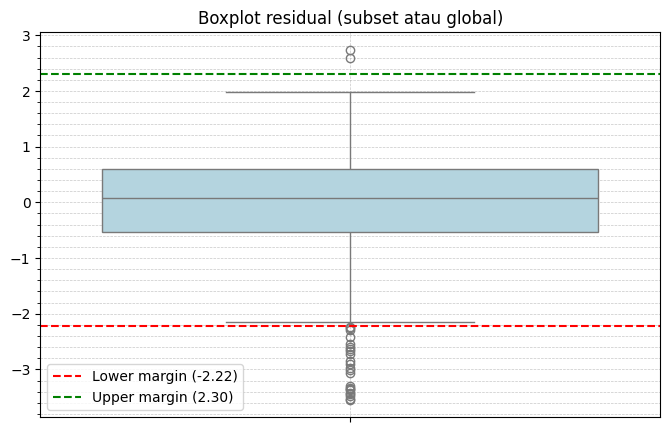

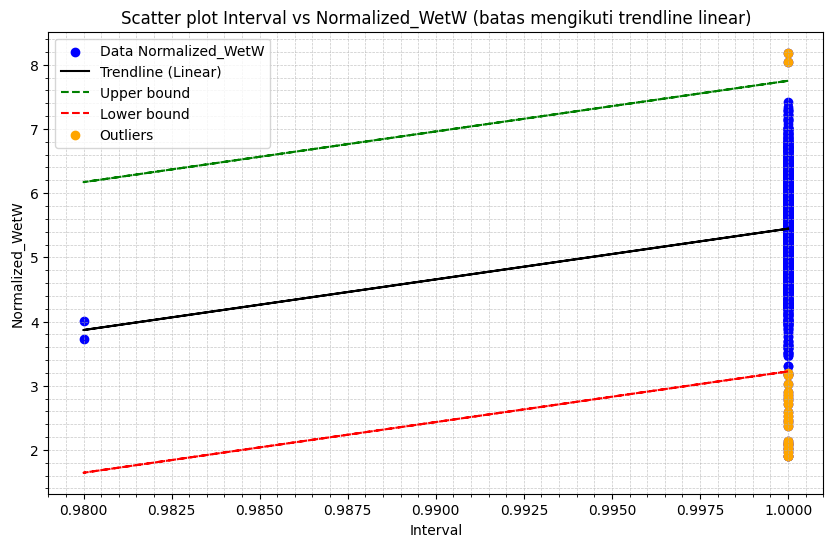

,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred,Outlier_Status
1957,CS7210355,Bintangor Blok 1 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.0,5.090,7.662,4.700,HGT,None,BRK,BRK,1.740979,1.607583,5.090,5.446461,Normal
1959,CD00096,MANGGURUH UTARA,BINTANGOR,2.0,3.0,1.0,1.0,5.950,3.133,5.764,BR_2,None,BRK,BRK,2.035132,1.971368,5.950,5.446461,Normal
1960,CD500074,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.0,6.208,4.317,5.940,SPT,None,BRK,BRK,2.123378,2.031712,6.208,5.446461,Normal
1961,CD500081,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.0,5.160,0.717,5.123,HSAP,None,BRK,BRK,1.764921,1.752266,5.160,5.446461,Normal
1962,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.0,5.625,4.782,5.356,SPT,None,BRK,BRK,1.923970,1.831961,5.625,5.446461,Normal
2973,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.0,5.757,5.556,5.437,BR_2,None,BRK,BRK,1.969119,1.859723,5.757,5.446461,Normal
2974,CD500090,BINTANGOR BARAT UTARA,BINTANGOR,3.0,4.0,1.0,1.0,6.834,1.463,6.734,HGT,None,BRK,BRK,2.337632,2.303428,6.834,5.446461,Normal
2975,CD500160,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.0,4.030,9.578,3.644,HSAP,None,BRK,BRK,1.378417,1.246390,4.030,5.446461,Normal
2976,CS7210119,Bintangor Blok 2 Spasi 50,BINTANGOR,3.0,4.0,1.0,1.0,3.590,8.691,3.278,HSAP,None,BRK,BRK,1.227920,1.121204,3.590,5.446461,Normal
2979,CD500213,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.0,4.108,20.594,3.262,RSAP,None,BRK,BRK,1.405096,1.115731,4.108,5.446461,Normal


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs Normalized_WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['Normalized_WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['Normalized_WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Tambahkan kolom status outlier ---
    def classify_outlier(val, pred):
        if val < pred + lower_margin:
            return "Outlier bawah"
        elif val > pred + upper_margin:
            return "Outlier atas"
        else:
            return "Normal"

    df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
    df_recovery['Outlier_Status'] = [
        classify_outlier(val, pred)
        for val, pred in zip(df_recovery['Normalized_WetW'], df_recovery['Trendline_Pred'])
    ]

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['Normalized_WetW'], color='blue', label='Data Normalized_WetW')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'], color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + upper_margin,
             color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + lower_margin,
             color='red', linestyle='--', label='Lower bound')

    # Outlier ditandai oranye
    outliers = df_recovery[df_recovery['Outlier_Status'] != "Normal"]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['Normalized_WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs Normalized_WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("Normalized_WetW")
    plt.legend()
    plt.show()

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
display(df_recovery.head(15))


Bin calculation:
Freedman–Diaconis -> bins=30, width=0.210934
Sturges -> bins=12, width=0.523750


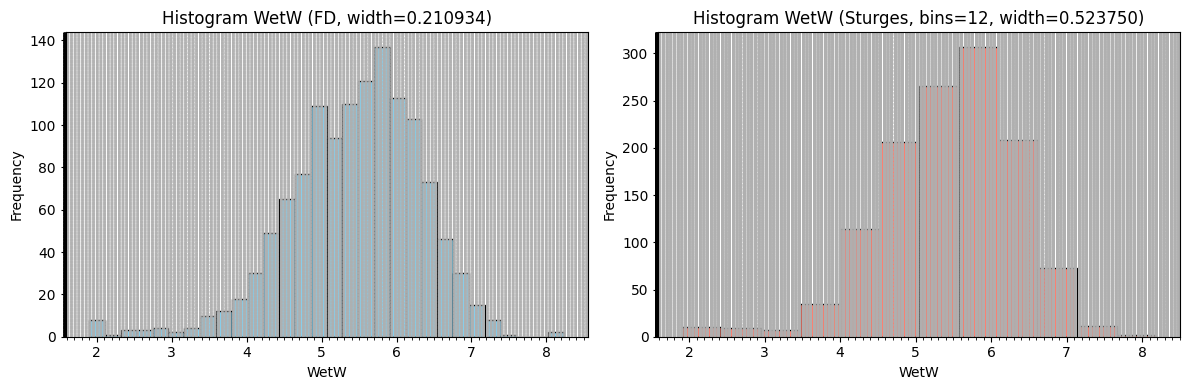


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,1.903000,2.113934,8
1,2.113934,2.324867,1
2,2.324867,2.535801,3
3,2.535801,2.746734,3
4,2.746734,2.957668,4
5,2.957668,3.168601,2
6,3.168601,3.379535,4
7,3.379535,3.590468,10
8,3.590468,3.801402,12
9,3.801402,4.012335,18



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,1.90300,2.42675,10
1,2.42675,2.95050,9
2,2.95050,3.47425,7
3,3.47425,3.99800,35
4,3.99800,4.52175,114
5,4.52175,5.04550,206
6,5.04550,5.56925,266
7,5.56925,6.09300,307
8,6.09300,6.61675,208
9,6.61675,7.14050,73


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def analyze_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns:
        print("Kolom 'WetW' tidak ada di dataframe.")
        return

    data = df_recovery['WetW'].dropna()
    if data.empty:
        print("Tidak ada data 'WetW' yang valid setelah drop NaN.")
        return

    # --- hitung jumlah bins ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram WetW (FD, width={width_fd_str})")
    axes[0].set_xlabel("WetW")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram WetW (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("WetW")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
wetw_data = analyze_wetw(df_recovery)

In [17]:
import numpy as np
from IPython.display import display

def filter_wetw_normal(df_recovery, lower_bound, upper_bound):
    """
    Filter data WetW berdasarkan batas bawah/atas,
    sekaligus memastikan hanya baris dengan Outlier_Status = 'Normal' yang lolos.
    Setelah selesai, kolom Outlier_Status dihapus.
    """
    # --- Filter berdasarkan WetW ---
    df_wetw = df_recovery[(df_recovery['WetW'] >= lower_bound) &
                          (df_recovery['WetW'] <= upper_bound)].copy()

    # --- Pastikan hanya baris Normal yang lolos ---
    if 'Outlier_Status' in df_wetw.columns:
        df_wetw = df_wetw[df_wetw['Outlier_Status'] == "Normal"].copy()
        # Drop kolom Outlier_Status setelah selesai
        df_wetw = df_wetw.drop(columns=['Outlier_Status'])
    else:
        print("Kolom Outlier_Status tidak ditemukan, hanya filter WetW yang diterapkan.")

    print(f"\nFiltered rows (Normal only): {len(df_wetw)}")
    display(df_wetw.head(10))

    return df_wetw

# --- Contoh pemanggilan ---
lower_bound = float(input("Masukkan batas bawah (>=): "))
upper_bound = float(input("Masukkan batas atas (<=): "))

df_wetw = filter_wetw_normal(df_recovery, lower_bound, upper_bound)

Masukkan batas bawah (>=): 4.434202
Masukkan batas atas (<=): 6.543538

Filtered rows (Normal only): 1002


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
1957,CS7210355,Bintangor Blok 1 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.0,5.090,7.662,4.700,HGT,None,BRK,BRK,1.740979,1.607583,5.090,5.446461
1959,CD00096,MANGGURUH UTARA,BINTANGOR,2.0,3.0,1.0,1.0,5.950,3.133,5.764,BR_2,None,BRK,BRK,2.035132,1.971368,5.950,5.446461
1960,CD500074,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.0,6.208,4.317,5.940,SPT,None,BRK,BRK,2.123378,2.031712,6.208,5.446461
1961,CD500081,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.0,5.160,0.717,5.123,HSAP,None,BRK,BRK,1.764921,1.752266,5.160,5.446461
1962,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.0,5.625,4.782,5.356,SPT,None,BRK,BRK,1.923970,1.831961,5.625,5.446461
2973,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.0,5.757,5.556,5.437,BR_2,None,BRK,BRK,1.969119,1.859723,5.757,5.446461
2980,CD500074,BINTANGOR BARAT UTARA,BINTANGOR,3.0,4.0,1.0,1.0,6.241,2.660,6.075,SPT,None,BRK,BRK,2.134666,2.077887,6.241,5.446461
2981,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,3.0,4.0,1.0,1.0,6.048,2.149,5.918,SPT,None,BRK,BRK,2.068652,2.024187,6.048,5.446461
2982,CD00096,MANGGURUH UTARA,BINTANGOR,3.0,4.0,1.0,1.0,5.203,3.664,5.012,BR_3,None,BRK,BRK,1.779629,1.714421,5.203,5.446461
2983,CD500073,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.0,6.240,1.522,6.145,DNT,None,BRK,BRK,2.134324,2.101830,6.240,5.446461


#Filter By MC


Descriptive statistics for H2O:
Count: 1002
Mean: 5.938970
Standard Error: 0.166822
Median: 4.5935
Mode: 2.0
Standard Deviation: 5.280643
Sample Variance: 27.885194
Kurtosis: 70.348237
Skewness: 5.649529
Range: 90.06800000000001
Minimum: 0.079
Maximum: 90.147
Sum: 5950.848
Confidence Level (95%): ±0.327361

Bin calculation:
Freedman–Diaconis -> bins=97, width=0.935677
Sturges -> bins=11, width=8.188000


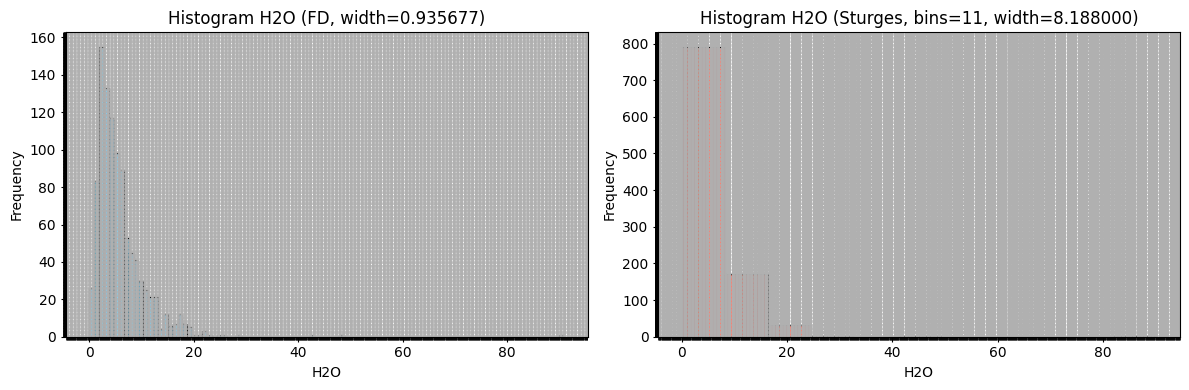


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.079000,1.014677,26
1,1.014677,1.950353,83
2,1.950353,2.886030,155
3,2.886030,3.821707,133
4,3.821707,4.757383,117
...,...,...,...
92,86.161250,87.096927,0
93,87.096927,88.032603,0
94,88.032603,88.968280,0
95,88.968280,89.903957,0



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.079,8.267,791
1,8.267,16.455,172
2,16.455,24.643,33
3,24.643,32.831,3
4,32.831,41.019,0
5,41.019,49.207,2
6,49.207,57.395,0
7,57.395,65.583,0
8,65.583,73.771,0
9,73.771,81.959,0


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="H2O"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_h2o(df_wetw):
    if 'H2O' not in df_wetw.columns:
        print("Kolom 'H2O' tidak ada di dataframe.")
        return

    data = df_wetw['H2O'].dropna()
    if data.empty:
        print("Tidak ada data 'H2O' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="H2O")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram H2O (FD, width={width_fd_str})")
    axes[0].set_xlabel("H2O")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram H2O (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("H2O")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
h2o_data = analyze_h2o(df_wetw)

In [21]:

import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_wetw berdasarkan H2O
df_h2o = df_wetw[(df_wetw['H2O'] >= lower_bound) &
                 (df_wetw['H2O'] <= upper_bound)].copy()

print(f"\nFiltered rows (H2O): {len(df_h2o)}")
display(df_h2o.head(10))

is greater than or equal to: 0.079
is less than or equal to: 8.267

Filtered rows (H2O): 791


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
1957,CS7210355,Bintangor Blok 1 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.0,5.090,7.662,4.700,HGT,None,BRK,BRK,1.740979,1.607583,5.090,5.446461
1959,CD00096,MANGGURUH UTARA,BINTANGOR,2.0,3.0,1.0,1.0,5.950,3.133,5.764,BR_2,None,BRK,BRK,2.035132,1.971368,5.950,5.446461
1960,CD500074,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.0,6.208,4.317,5.940,SPT,None,BRK,BRK,2.123378,2.031712,6.208,5.446461
1961,CD500081,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.0,5.160,0.717,5.123,HSAP,None,BRK,BRK,1.764921,1.752266,5.160,5.446461
1962,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.0,5.625,4.782,5.356,SPT,None,BRK,BRK,1.923970,1.831961,5.625,5.446461
2973,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.0,5.757,5.556,5.437,BR_2,None,BRK,BRK,1.969119,1.859723,5.757,5.446461
2980,CD500074,BINTANGOR BARAT UTARA,BINTANGOR,3.0,4.0,1.0,1.0,6.241,2.660,6.075,SPT,None,BRK,BRK,2.134666,2.077887,6.241,5.446461
2981,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,3.0,4.0,1.0,1.0,6.048,2.149,5.918,SPT,None,BRK,BRK,2.068652,2.024187,6.048,5.446461
2982,CD00096,MANGGURUH UTARA,BINTANGOR,3.0,4.0,1.0,1.0,5.203,3.664,5.012,BR_3,None,BRK,BRK,1.779629,1.714421,5.203,5.446461
2983,CD500073,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.0,6.240,1.522,6.145,DNT,None,BRK,BRK,2.134324,2.101830,6.240,5.446461


# Filter By DTF


Descriptive statistics for DTF:
Count: 791
Mean: 1.843990
Standard Error: 0.006867
Median: 1.855561799
Mode: 1.908577851
Standard Deviation: 0.193133
Sample Variance: 0.037300
Kurtosis: -0.868179
Skewness: -0.199367
Range: 0.807896215
Minimum: 1.405438421
Maximum: 2.213334636
Sum: 1458.5963019760002
Confidence Level (95%): ±0.013480

Bin calculation:
Freedman–Diaconis -> bins=13, width=0.065832
Sturges -> bins=11, width=0.073445


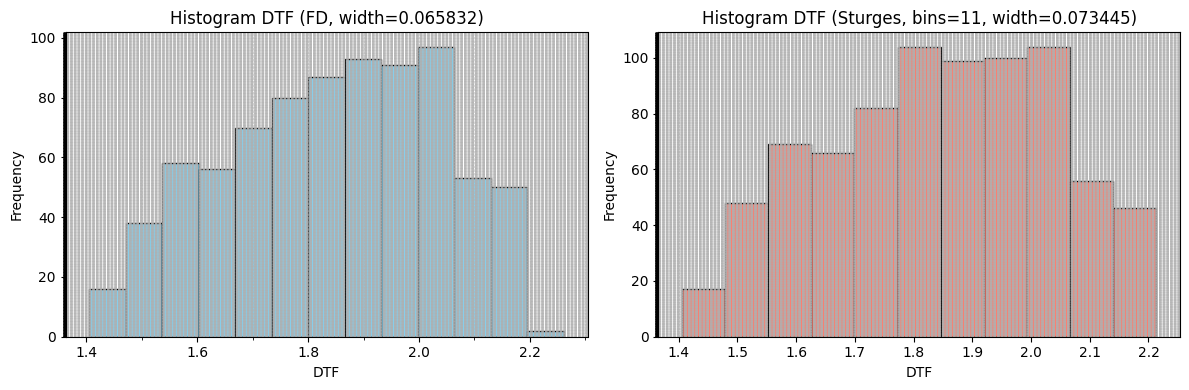


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,1.405438,1.471270,16
1,1.471270,1.537102,38
2,1.537102,1.602934,58
3,1.602934,1.668766,56
4,1.668766,1.734598,70
5,1.734598,1.800430,80
6,1.800430,1.866262,87
7,1.866262,1.932094,93
8,1.932094,1.997926,91
9,1.997926,2.063758,97



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,1.405438,1.478884,17
1,1.478884,1.552329,48
2,1.552329,1.625774,69
3,1.625774,1.699219,66
4,1.699219,1.772664,82
5,1.772664,1.846109,104
6,1.846109,1.919554,99
7,1.919554,1.992999,100
8,1.992999,2.066444,104
9,2.066444,2.139890,56


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="DTF"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_dtf(df_h2o):
    if 'DTF' not in df_h2o.columns:
        print("Kolom 'DTF' tidak ada di dataframe.")
        return

    data = df_h2o['DTF'].dropna()
    if data.empty:
        print("Tidak ada data 'DTF' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="DTF")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram DTF (FD, width={width_fd_str})")
    axes[0].set_xlabel("DTF")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram DTF (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("DTF")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
dtf_data = analyze_dtf(df_h2o)

In [23]:
import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_h2o berdasarkan DTF
df_dtf = df_h2o[(df_h2o['DTF'] >= lower_bound) &
                (df_h2o['DTF'] <= upper_bound)].copy()

print(f"\nFiltered rows (DTF): {len(df_dtf)}")
display(df_dtf.head(89))

is greater than or equal to: 1.668766
is less than or equal to: 2.063758

Filtered rows (DTF): 518


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
1959,CD00096,MANGGURUH UTARA,BINTANGOR,2.0,3.0,1.0,1.0,5.950,3.133,5.764,BR_2,None,BRK,BRK,2.035132,1.971368,5.950,5.446461
1960,CD500074,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.0,6.208,4.317,5.940,SPT,None,BRK,BRK,2.123378,2.031712,6.208,5.446461
1961,CD500081,BINTANGOR BARAT UTARA,BINTANGOR,2.0,3.0,1.0,1.0,5.160,0.717,5.123,HSAP,None,BRK,BRK,1.764921,1.752266,5.160,5.446461
1962,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,2.0,3.0,1.0,1.0,5.625,4.782,5.356,SPT,None,BRK,BRK,1.923970,1.831961,5.625,5.446461
2973,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.0,1.0,1.0,5.757,5.556,5.437,BR_2,None,BRK,BRK,1.969119,1.859723,5.757,5.446461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7329,CS6210137,Bintangor Blok 2 Spasi 25,BINTANGOR,7.0,8.0,1.0,1.0,5.840,1.884,5.730,DNT,None,BRK,BRK,1.997508,1.959884,5.840,5.446461
7330,CS7210270,Bintangor Blok 1 Spasi 50,BINTANGOR,7.0,8.0,1.0,1.0,5.640,6.560,5.270,HGT,None,BRK,BRK,1.929100,1.802546,5.640,5.446461
7331,CD500200,BINTANGOR BARAT SELATAN,BINTANGOR,7.0,8.0,1.0,1.0,5.975,3.163,5.786,HSAP,None,BRK,BRK,2.043683,1.979038,5.975,5.446461
7332,CD500188,BINTANGOR BARAT SELATAN,BINTANGOR,7.0,8.0,1.0,1.0,5.077,1.536,4.999,DNT,None,BRK,BRK,1.736532,1.709853,5.077,5.446461


# SUMMARY

In [24]:
import numpy as np
import scipy.stats as stats

def descriptive_stats(series, label):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

# --- Jalankan untuk semua kolom yang diminta ---
target_columns = ["Interval", "CoreRec", "WetW", "H2O", "DryW", "WTF", "DTF"]

for col in target_columns:
    if col in df_dtf.columns:
        descriptive_stats(df_dtf[col], label=col)
    else:
        print(f"\nKolom {col} tidak ditemukan di df_dtf.")


Descriptive statistics for Interval:
Count: 518
Mean: 1.000000
Standard Error: 0.000000
Median: 1.0
Mode: 1.0
Standard Deviation: 0.000000
Sample Variance: 0.000000
Kurtosis: N/A
Skewness: N/A
Range: 0.0
Minimum: 1.0
Maximum: 1.0
Sum: 518.0
Confidence Level (95%): ±0.000000

Descriptive statistics for CoreRec:
Count: 518
Mean: 1.000000
Standard Error: 0.000000
Median: 1.0
Mode: 1.0
Standard Deviation: 0.000000
Sample Variance: 0.000000
Kurtosis: N/A
Skewness: N/A
Range: 0.0
Minimum: 1.0
Maximum: 1.0
Sum: 518.0
Confidence Level (95%): ±0.000000

Descriptive statistics for WetW:
Count: 518
Mean: 5.720143
Standard Error: 0.014571
Median: 5.7455
Mode: 5.88
Standard Deviation: 0.331626
Sample Variance: 0.109976
Kurtosis: -0.879728
Skewness: -0.148435
Range: 1.4669999999999996
Minimum: 4.993
Maximum: 6.46
Sum: 2963.0339999999997
Confidence Level (95%): ±0.028625

Descriptive statistics for H2O:
Count: 518
Mean: 4.065542
Standard Error: 0.080976
Median: 3.944
Mode: 2.948
Standard Deviation: 

/tmp/ipython-input-1308544473.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = stats.kurtosis(data) if n > 3 else np.nan
/tmp/ipython-input-1308544473.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(data) if n > 2 else np.nan


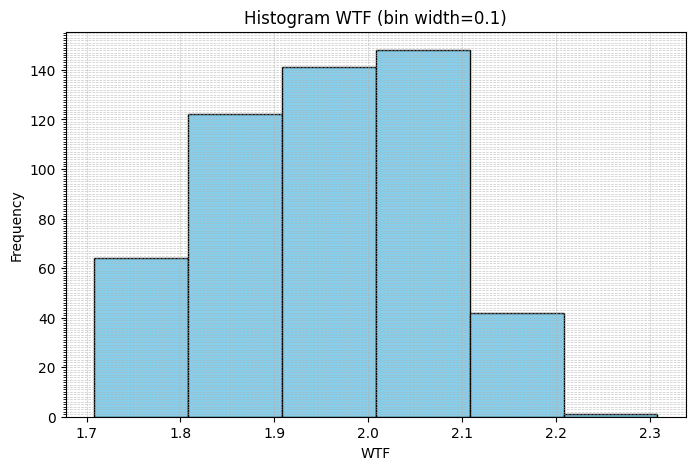


Tabel Histogram WTF:


,Bin Start,Bin End,Frequency
0,1.707801,1.807801,64
1,1.807801,1.907801,122
2,1.907801,2.007801,141
3,2.007801,2.107801,148
4,2.107801,2.207801,42
5,2.207801,2.307801,1


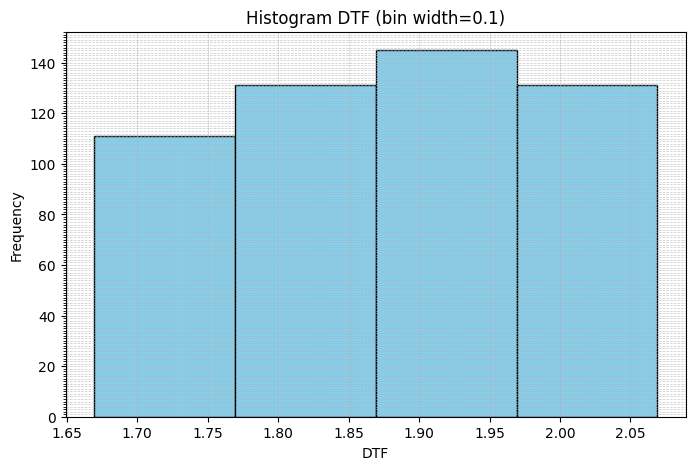


Tabel Histogram DTF:


,Bin Start,Bin End,Frequency
0,1.669151,1.769151,111
1,1.769151,1.869151,131
2,1.869151,1.969151,145
3,1.969151,2.069151,131


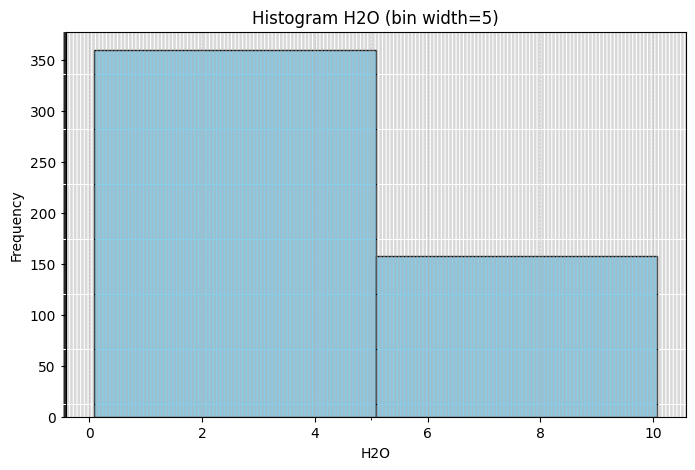


Tabel Histogram H2O:


,Bin Start,Bin End,Frequency
0,0.079,5.079,360
1,5.079,10.079,158


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator

def plot_histogram_fixed_width(series, bin_width, label):
    data = series.dropna().values
    if len(data) == 0:
        print(f"Tidak ada data untuk {label}.")
        return None

    # Tentukan bins berdasarkan bin_width
    min_val, max_val = data.min(), data.max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Plot histogram
    plt.figure(figsize=(8,5))
    counts, edges, _ = plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"Histogram {label} (bin width={bin_width})")
    plt.xlabel(label)
    plt.ylabel("Frequency")

    # Minor ticks sesuai bin width
    plt.gca().xaxis.set_minor_locator(MultipleLocator(bin_width))
    plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    # Buat tabel histogram
    table = pd.DataFrame({
        "Bin Start": edges[:-1],
        "Bin End": edges[1:],
        "Frequency": counts.astype(int)
    })

    print(f"\nTabel Histogram {label}:")
    display(table)
    return table

# --- Contoh pemanggilan ---
table_wtf = plot_histogram_fixed_width(df_dtf['WTF'], bin_width=0.1, label="WTF")
table_dtf = plot_histogram_fixed_width(df_dtf['DTF'], bin_width=0.1, label="DTF")
table_h2o = plot_histogram_fixed_width(df_dtf['H2O'], bin_width=5, label="H2O")

In [26]:
import pandas as pd

# Input nama Block, GEN_LYR, dan Material
block_name = input("Masukkan nama Block: ")
gen_lyr = input("Masukkan GEN_LYR: ")

# Hitung nilai ringkasan (contoh: mean)
summary = {
    "Block": block_name,
    "GEN_LYR": gen_lyr,
    "Interval_mean": df_dtf['Interval'].dropna().mean(),
    "CoreRec_mean": df_dtf['CoreRec'].dropna().mean(),
    "WetW_mean": df_dtf['WetW'].dropna().mean(),
    "H2O_mean": df_dtf['H2O'].dropna().mean(),
    "DryW_mean": df_dtf['DryW'].dropna().mean(),
    "WTF_mean": df_dtf['WTF'].dropna().mean(),
    "DTF_mean": df_dtf['DTF'].dropna().mean()
}

# Buat nama variabel DataFrame sesuai input
var_name = f"df_{block_name.replace(' ', '_').lower()}_{gen_lyr.lower()}"
globals()[var_name] = pd.DataFrame([summary])

print(f"\nTabel Ringkasan tersimpan sebagai variabel: {var_name}")
display(globals()[var_name])

Masukkan nama Block: Bintangor
Masukkan GEN_LYR: BRK

Tabel Ringkasan tersimpan sebagai variabel: df_bintangor_brk


,Block,GEN_LYR,Interval_mean,CoreRec_mean,WetW_mean,H2O_mean,DryW_mean,WTF_mean,DTF_mean
0,Bintangor,BRK,1.0,1.0,5.720143,4.065542,5.487008,1.956512,1.876772
